# 9. GLMのベイズモデル化と事後分布の推定
* 複数のパラメーターをもつGLMのベイズモデル化、そしてそのパラメーターの事後分布の推定方法について扱う

#### 滝沢補足
* ベイズは統計学の考え方の1つ。統計モデルを推定する道具。([参考](http://logics-of-blue.com/%E3%83%99%E3%82%A4%E3%82%BA%E3%81%A8%E7%B5%B1%E8%A8%88%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E9%96%A2%E4%BF%82/))

#### 実装の方針

* この本ではWinBUGSというソフトウェアを使用している。しかし、Macだと微妙そう。
    * 今はStanがコミュニティが大きいこと、またネット上にも情報が多いことから、Stanがお勧めとのこと。(TJOさんの[ツイート](https://twitter.com/TJO_datasci/status/883643447126757376))
* 具体的なコードは飛ばし、流れだけ記載します。
* Stanについては、[StanとRでベイズ統計モデリング](http://amzn.to/2uVu97t)　（通称アヒル本）が良さそうです。
* Stanの特徴としては、推定計算のアルゴリズムに、MCMCの一種である、Hamiltonian Monte Carloの一実装である、NUTSが使われている点にあるそうです。(緑本内で紹介されている手法とは異なる)

## 9.1. 例題：種子数のポアソン回帰（個体差なし）

* 例題の目的
    * 個体ごとの平均種子数が、体サイズ$x_i$にどう依存しているのか調べる
* まずはこの例題のGLMをベイズ統計モデル化する方法について検討し、そのパラメータの事後分布の推定に取り組む。

### Code1

In [1]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data_file = "./input/chap9.csv"
df = pd.read_csv(data_file)

In [2]:
df.head()

,Unnamed: 0,x,y
0,1,3.000000,5
1,2,3.210526,3
2,3,3.421053,6
3,4,3.631579,7
4,5,3.842105,7


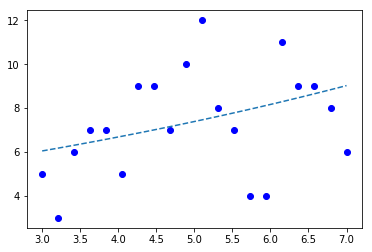

In [3]:
plt.plot(df.x,df.y,"bo")
xx = np.linspace(3,7,100)
yy = np.exp(1.5+0.1*xx)
plt.plot(xx,yy,"--")

## 9.2. GLMのベイズモデル化

* ベイズモデル化したGLMでも、モデルの中核部分はポアソン回帰のGLM。
* 個体$i$の種子数$y_i$のばらつきを平均$\lambda_i$のポアソン分布$p(y_i|\lambda_i)$に従うとする。
* 平均を下記と指定。
$$
\lambda_i = \exp(\beta_1+\beta_2 x_i)
$$
* モデルの尤度関数は下記。
$$
L(\beta_1,\beta_2)=\prod_i p(y_i|\lambda_i) = \prod_i p(y_i|\beta_1,\beta_2,x_i)
$$
* この例題でも説明変数$x_i$を定数のように扱う。
* 尤度関数は離散確率分布で定義されているので、（ポアソン分布の尤度だから、離散確率分布ということ？）
$$
p({\bf Y}|\beta_1,\beta_2) = L(\beta_1,\beta_2)
$$
* ベイズモデルの事後分布は(尤度)$\times$(事前分布)に比例するので、
$$
p(\beta_1,\beta_2|{\bf Y}) \propto p({\bf Y}|\beta_1,\beta_2) p(\beta_1) p(\beta_2)
$$
    * (復習) p186 8.4.より。 ベイズ統計モデルとは、下記の構造を持つ統計モデル。
        * 事後分布 = 尤度$\times$事前分布 / データが得られる確率

## 9.3. 無情報事前分布

Q. ベイズ統計モデルにおける事前分布 $p(\beta_*)$とは？

A.
* 観測データ${\bf Y}$が得られていない時のパラメータ$\beta_*$の確率分布
* わかるはずもない

---

* そこで、線形予測子のパラメータ$\beta_*$の値は[$-\infty,\infty$]の範囲で「好きな値をとって良い」といったことを表現する事前分布$p(\beta_*)$を設定する。
    * 無情報事前分布
* しかし、区間全体で密度関数を積分しても1にならない
* そこで、「無情報っぽい」事前分布として下記の2種類が用いられる。
    1. 広い範囲をとる一様分布（$-10^9 < \beta_* < 10^9$など)
    2. 平べったい正規分布
        * 平均ゼロで標準偏差がとても大きい(標準偏差100など）

### Code2

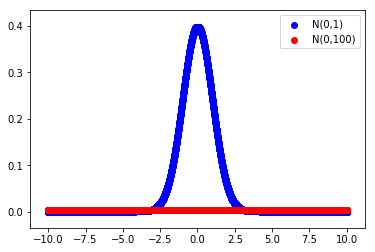

In [4]:
from scipy.stats import norm

n = np.linspace(-10,10,10000)

p_1=[]
p_100=[]
for i in range(len(n)):
    p_1.append(norm.pdf(x=n[i],loc=0,scale=1))
    p_100.append(norm.pdf(x=n[i],loc=0,scale=100))
    
plt.scatter(n,p_1,color="b",label="N(0,1)")
plt.scatter(n,p_100,color="r",label="N(0,100)")
plt.legend()

## 9.4. ベイズ統計モデルの事後分布の推定

* 9.3で、パラメータの事前分布$p(\beta_*)$を無情報事前分布と決めることができた
* 次に、このベイズ統計モデルと例題データに基づいて、切片$\beta_1$と傾き$\beta_2$の事後分布 ー つまり複数の連続値パラメータの事後分布$p(\beta_1,\beta_2|{\bf Y})$をMCMCサンプリングを使って推定する。

### 9.4.1. ベイズ統計モデルのコーディング

* まずはベイズモデル化したGLMをBUGSコードで表現
* ここではPyStanで記載。

### Code3

#### Stanのコード

In [5]:
model = """
data {
    int<lower=1> N;
    real X[N];
    int<lower=0> y[N];
    real xmean;
}

parameters {
    real beta1;
    real beta2;
}

model {
    # beta1,beta2に無情報事前分布を指定（平均と標準偏差）
    beta1 ~ normal(0, 100);
    beta2 ~ normal(0, 100);
    
    # y_1,y_2...にpoisson分布
    # lambda_iの指定には、対数リンク関数を使用
    for (i in 1:N){
        y[i] ~ poisson_log(beta1 + beta2 * (X[i] - xmean));
    }
}
"""

* (復習)対数リンク関数を式にすると、
$$
\log \lambda_i = \beta_1 + \beta_2 x_i
$$

### 9.4.2. 事後分布推定の準備

* データやパラメータの初期値、サンプリング回数の指示。
* 最初の何ステップの結果を使わないとするか、など。

### Code4

#### データの設定

In [6]:
X = df.x
y = df.y
N = X.shape[0]
xmean = X.mean()

# stanに辞書型でデータを引き渡す
stan_data = {"N": N, "X": X, "y": y,"xmean":xmean}

#### サンプリングの設定

In [7]:
# MCMCサンプリングのステップ数
iter_count= 1600

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
chain_count = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
warmup_count = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
thin_count = 3

fit = pystan.stan(model_code=model,
                  data=stan_data,
                  iter=iter_count,
                  chains=chain_count,
                  thin=thin_count,
                  warmup=warmup_count)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a822b8ef4fe7305bb018d2388fdda01 NOW.


* 数分かかると思います

### 9.4.3. どれだけ長くMCMCサンプリングすればいいのか

* MCMCサンプリングの結果から定常分布（この例題の場合は事後分布）を推定する。
* サンプリングする長さや値を記録する間隔に注意が必要
    1. サンプリング量が少ないと、事後分布を正確に推定できないので、量を多くすること。
    2. 複数のサンプリングの比較をすること。
        * 初期値の影響を受けてる範囲が掴める(これらは事後分布推定用の値としては望ましくない。）
       
        * データ・統計モデル・MCMCサンプリングのどこかに問題があれば、サンプル列ごとに異なる挙動を示す。
            * サンプル列間の乖離の大小を調べることを収束診断と呼ぶ
            
* 収束診断は$\hat R$指数で表すのが手軽。
    * $\hat R$が$1.0$に近ければ収束しているとみなす
    * $\hat R>1.1$となるような時には、サンプル列間のばらつきが大きいので、定常分布・事後分布は推定できないと判断する。
        * 収束しない時には、統計モデルや、サンプリング法に何か問題がある。

## 9.5. MCMCサンプルから事後分布を推定

* 500個$\times $3ステップのサンプル列をえた。これらを図示する。
* 個々のパラメーターの事後分布の様子を把握する(図9.5)
* 図9.5(B)(D)は$\beta_1,\beta_2$それぞれの周辺事後分布
* 図9.6(A)は事後分布からのサンプルの組み合わせごとに平均$\lambda$を計算し、一本ずつ直線を引いている。
* 図9.6(B)は$\beta_1,\beta_2$の散布図。

### Code5

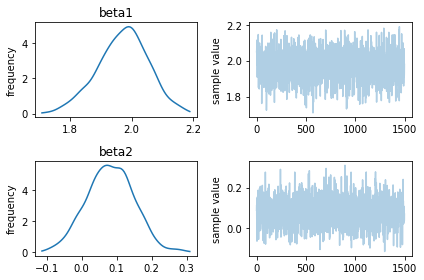

In [8]:
fit.plot()
plt.tight_layout()

* 各Chainから500ずつサンプルを得ており、それを3つのChainまとめて1500のサンプルにしている。

### Code6

In [9]:
df_sample = pd.DataFrame()
df_sample["beta1"] = fit.extract()["beta1"]
df_sample["beta2"] = fit.extract()["beta2"]

In [10]:
fit.extract()

OrderedDict([('beta1',
              array([ 2.0498271 ,  2.05171136,  2.07841622, ...,  1.90734921,
                      1.92146166,  1.97869278])),
             ('beta2',
              array([ 0.08880871,  0.11475287,  0.003501  , ...,  0.10750436,
                      0.03794356,  0.0702879 ])),
             ('lp__',
              array([ 144.62832022,  144.46460461,  143.67372546, ...,  144.54229314,
                      144.44851727,  144.95390928]))])

In [11]:
df_sample.head()

,beta1,beta2
0,2.049827,0.088809
1,2.051711,0.114753
2,2.078416,0.003501
3,1.978448,0.133783
4,1.993521,-0.062687


(3, 12)

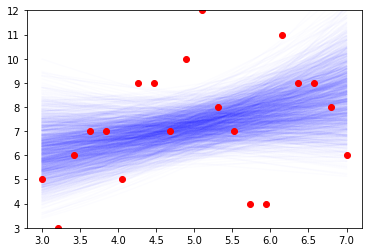

In [12]:
xx = np.linspace(3,7,100)

for i in range(df_sample.shape[0]):
    beta1 = df_sample.beta1[i]
    beta2 = df_sample.beta2[i]

    yy = np.exp(beta1+beta2*(xx - xmean))
    
    plt.plot(xx,yy,color="b",alpha=0.01)

plt.plot(df.x,df.y,"ro")
plt.ylim(3,12)

* xxからはx平均を引いたものにbeta2をかけている。
* 図9.6にはその説明がなく、「$\lambda =\exp(\beta_1 + \beta_2 x)$」としているが、正しくは、$\lambda =\exp(\beta_1 + \beta_2 (x-x_{mean}))$では？

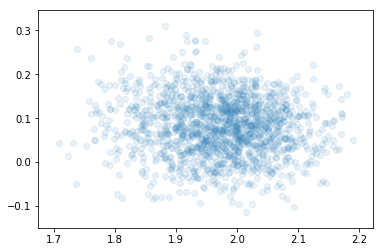

In [13]:
plt.scatter(df_sample.beta1,df_sample.beta2,alpha=0.1)

### 9.5.1. 事後分布の統計量

* $\beta_,\beta_2$の平均、中央値、95％信用区間など。

#### Code7

In [14]:
print(fit)

Inference for Stan model: anon_model_7a822b8ef4fe7305bb018d2388fdda01.
3 chains, each with iter=1600; warmup=100; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1   1.97  2.3e-3   0.08    1.8   1.92   1.98   2.03   2.13   1226    1.0
beta2   0.08  1.7e-3   0.07  -0.05   0.04   0.08   0.13   0.21   1500    1.0
lp__  144.01    0.03   0.95 141.45 143.63  144.3  144.7 144.95   1328    1.0

Samples were drawn using NUTS at Tue Jul 11 16:46:23 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


* "lp__"は対数確率密度
* $\hat R$は$\beta_1,\beta_2$共に1.0で問題なさそう。

## 9.6. 複数パラメーターのMCMCサンプリング

* MCMCアルゴリズムについて説明
* 複数パラメーターの事後分布からMCMCサンプリングする方法を考えてみる。
* MCMCサンプリングとは、値を少しずつ変更していく方式。
    * しかし、複数のパラメーターを同時に変更するのは難しい。
        * そこで、$\beta_1,\beta_2$の値を交互に更新する方法をとってみる。

### 9.6.1. ギブスサンプリング：この章の例題の場合

* 様々なアルゴリズムを使ってMCMCサンプリングする。
    * その中でもギブスサンプリングが特に重要。
* ギブスサンプリングとメトロポリス法の相違点
    * メトロポリス法：新しい値の候補をあげ、それに変化するかどうかを決める
    * ギブスサンプリング：「新しい値の確率分布」を作り、その確率分布のランダムサンプルを新しい値とする。
        * 「新しい値の確率分布」とは、多変量確率分布から一つの変量を除いて、他の変量全てを定数とする一変量確率分布。(全条件付き分布(FCD))
        * メトロポリス法と比較した利点
            * 各MCMCステップにおいて、元の値と更新された値の相関がより小さい(参考：8.3.2.マルコフ連鎖の定常分布)
            * MCMCサンプリングの詳細を指定しなくても良い
* ギブスサンプリングのアルゴリズム
    1. パラメータ($\beta_1,\beta_2$)の初期値を何か決める。
    2. 他のパラメーター($\beta_2$)を定数として、あるパラメーター($\beta_1$)のFCDを求める。
    3. このFCDに従う乱数を1つ発生させ、 パラメーター($\beta_1$)を更新する。
    4. 他のパラメーター($\beta_2$)について、同様に乱数を発生させ、更新する。
    5. ここまでで第1MCMCステップが終了。引き続き、交互にサンプリングする。

### 9.6.2. WinBUGSの挙動はどうなっている？

* 教科書参照

## 9.7. この章のまとめと参考文献

* この章の主題
    * GLMのベイズモデル化
    * 複数のパラメーターの事後分布からのMCMCサンプリング
    
* 全個体に共通するパラメーターの事前分布として、「どのような値でも構わない」ことを表現する無情報事前分布を指定する
* ベイズ統計モデル化したGLMを記述する
* MCMCサンプリングを行い、事後分布の統計量の分布を把握。MCMCサンプル列の収束診断を行う
* ギブスサンプリングについて
* ベイズ統計モデルでもモデル選択ができれば良いが、手法が定まっていない
    * 交差検証法
    * DIC

### 参考サイト、書籍

下記のサイトを参考にさせていただきました。
* [データ解析のためのモデリング入門第9章をPyStanで - 人間だったら考えて ](http://szdr.hatenablog.com/entry/2016/06/26/004838)
* [データ解析のための統計モデリング入門9章後半](https://www.slideshare.net/moa108/9-38868144)
* [StanとRでベイズ統計モデリング](http://amzn.to/2uVu97t)　